In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as st
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

In [2]:
#Importation fichier source
data_7 = pd.read_csv(r"C:\Users\elodi\Documents\DATA\Data Analyst\Projets\P7\wid_500.csv")
data_7.head()

country_code  country  quantile  nb_quantiles      income  gdpppp  gini  \
0          ALB  Albania         1           100   728.89795  7297.0   0.3   
1          ALB  Albania         2           100   916.66235  7297.0   0.3   
2          ALB  Albania         3           100  1010.91600  7297.0   0.3   
3          ALB  Albania         4           100  1086.90780  7297.0   0.3   
4          ALB  Albania         5           100  1132.69970  7297.0   0.3   

    avg_income        pj  c_k_parent  
0  2994.829902  0.815874           1  
1  2994.829902  0.815874           1  
2  2994.829902  0.815874           1  
3  2994.829902  0.815874           1  
4  2994.829902  0.815874           1

#### Premi√®re approche : repr√©sentation visuelle selon les 9 pays identifi√©s lors du clustering

In [3]:
country_list = ['Luxembourg', 'Sweden', 'Spain', 'France', 'Norway', 'United States', 'Denmark', 'Austria', 'Czech Republic	']
data_7_country_list = data_7[data_7['country'].isin(country_list)]

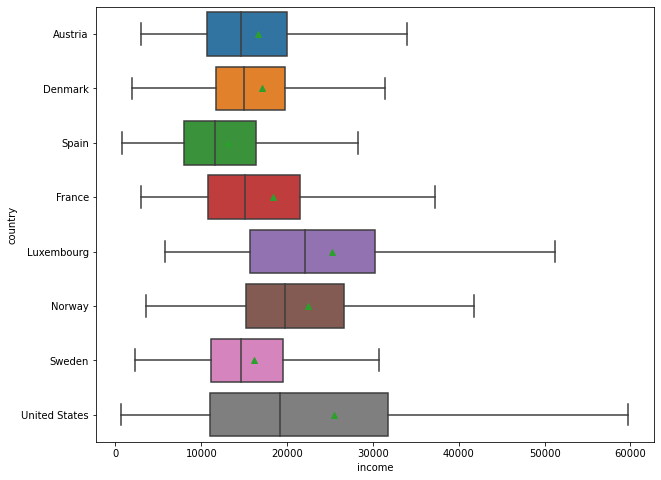

In [4]:
plt.figure(figsize=(10,8))
sns.boxplot(
    data=data_7_country_list, 
    x='income', y='country', 
    showfliers=False, showmeans=True)

plt.savefig('boxplot_panel_income.png')
plt.show()

On constate ici que les donn√©es analys√©es ne semblent pas √™tre de variances √©gales.

La but est de savoir si ces √©carts sont significatifs ou pas. L'ANOVA nous permettra de r√©pondre √† cette question.

#### ANOVA
Appliquez une ANOVA sur vos donn√©es, en n‚Äôincluant comme variable explicative que le pays de l‚Äôindividu. Analysez la performance du mod√®le

In [5]:
anova_income = smf.ols('income ~ country', data=data_7).fit()
print(anova_income.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 4.971e+04
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:42:25   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799884   BIC:                         1.186e+08
Df Model:                         115                                         
Covariance Type:            nonrobust                                         


R¬≤ = 0.496, on peut en conclure que la variable explicative Pays explique pr√®s de 50% de la variance du revenu de l'individu. Le reste, donc la moiti√© de la variance sur le revenu, est expliqu√©e par les autres facteurs non consid√©r√©s dans ce mod√®le.

#### Test de fisher
Ce qui nous int√©resse r√©ellement, c'est le test de Fisher. La p-valeur de ce test ( 0 ) est tr√®s petite et largement inf√©rieure √† 5 %. On rejette donc l'hypoth√®se H0 selon laquelle Œ±1=Œ±2=Œ±3=Œ±4=0 .

Le pays a donc bien un effet sur les revenus

In [6]:
sm.stats.anova_lm(anova_income, typ=2)

sum_sq         df             F  PR(>F)
country   2.551188e+14      115.0  49710.758889     0.0
Residual  2.588293e+14  5799884.0           NaN     NaN

In [7]:
test=sm.stats.anova_lm(anova_income, typ=2)
SCE=test.iloc[0,0]
SCR=test.iloc[1,0]
variab_pays=SCE/(SCE+SCR)

variab_pays

0.49639014230948464

#### 1√®re r√©gression lin√©aire 
R√©gression lin√©aire sur nos donn√©es, en incluant comme variables explicatives uniquement le revenu moyen du pays de l‚Äôindividu et l‚Äôindice de Gini du pays de l‚Äôindividu. Quel est le pourcentage de variance expliqu√©e par le(s) mod√®le(s) ?

In [8]:
rl_1 = smf.ols('income ~ gini + avg_income', data=data_7).fit()
print(rl_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 2.858e+06
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:42:28   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799997   BIC:                         1.186e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.903e-10     14.960   1.94e-11      1.0

Ce mod√®le n'explique que 50% de la variance, nous ne sommes pas plus performants que l'ANOVA. Il peut s'agir d'un probl√®me de lin√©arit√©, car les salaires ont tendance √† √©voluer de mani√®re exponentielle.

##### Visualisation

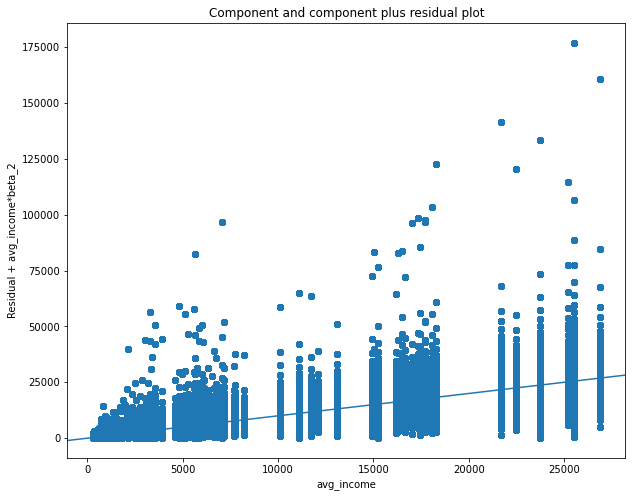

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = sm.graphics.plot_ccpr(rl_1, "avg_income", ax=ax)

#### 2√®me r√©gression lin√©aire 
Logarithme du Revenu moyen du pays de l‚Äôindividu et l‚Äôindice de Gini du pays de l‚Äôindividu

Ajout des colonnes de log

In [10]:
data_7['ln_avg_income'] = np.log(data_7['avg_income'])

In [11]:
data_7['ln_income'] = np.log(data_7['income'])

In [12]:
#2√®me r√©gression lin√©aire
rl_2 = smf.ols('ln_income ~ gini + ln_avg_income', data=data_7).fit()
print(rl_2.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 7.773e+06
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:42:40   Log-Likelihood:            -6.3237e+06
No. Observations:             5800000   AIC:                         1.265e+07
Df Residuals:                 5799997   BIC:                         1.265e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4713      0.003    162.377

Ce mod√®le bas√© sur le logarithme de l'income et average income est donc meilleur que le premier. Le R2 est ici de 0.729

##### Visualisation

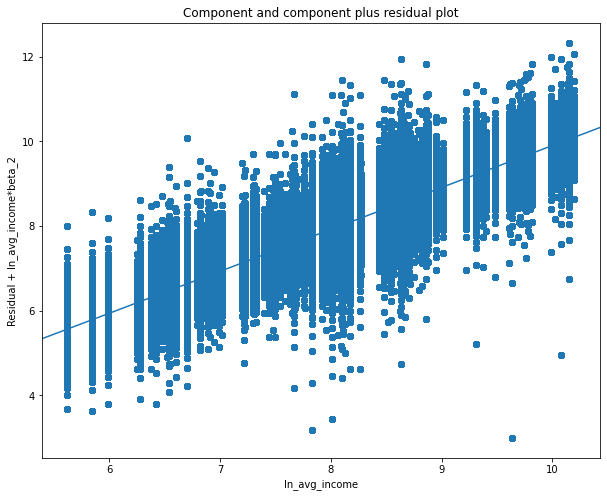

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = sm.graphics.plot_ccpr(rl_2, "ln_avg_income", ax=ax)

In [14]:
anova_table_gini_ln = sm.stats.anova_lm(rl_2, typ=2)
anova_table_gini_ln["eta_sq"] = anova_table_gini_ln[:-1]['sum_sq']/sum(anova_table_gini_ln['sum_sq'])
anova_table_gini_ln

sum_sq         df             F  PR(>F)    eta_sq
gini           1.093747e+05        1.0  2.110422e+05     0.0  0.010781
ln_avg_income  7.030267e+06        1.0  1.356513e+07     0.0  0.692941
Residual       3.005907e+06  5799997.0           NaN     NaN       NaN

In [15]:
#Autre m√©thode de calcul de la variance expliqu√©e du mod√®le
var_exp_model = round((rl_2.ess / rl_2.centered_tss)*100,2)
var_exp_model

72.83

D√©composition de la variance :

In [16]:
var_exp_pays = round(sum(anova_table_gini_ln[0:2]["eta_sq"])*100,2)
print("Le pourcentage de la variance expliqu√©e par le pays de naissance est donc de :",var_exp_pays,"%")

Le pourcentage de la variance expliqu√©e par le pays de naissance est donc de : 70.37 %


In [17]:
var_exp_autres = round(var_exp_model - var_exp_pays,2)
print("Le pourcentage de la variance expliqu√©e par les autres facteurs non consid√©r√©s est donc de :",var_exp_autres,"%")

Le pourcentage de la variance expliqu√©e par les autres facteurs non consid√©r√©s est donc de : 2.46 %


In [18]:
#Variance totale SCT
rl_2.centered_tss

11062516.886050463

In [19]:
#Variance expliqu√©e SCE
rl_2.ess

8056609.94861871

In [20]:
#Variance r√©siduelle SCR
rl_2.ssr

3005906.9374317527

#### 3eme r√©gression lin√©aire
Am√©lioration du dernier mod√®le avec la classe de revenus des parents

In [21]:
rl_3 = smf.ols('ln_income ~ ln_avg_income + gini + c_k_parent', data=data_7).fit()
print(rl_3.summary())

                            OLS Regression Results                            
Dep. Variable:              ln_income   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                 5.386e+06
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:42:52   Log-Likelihood:            -6.2418e+06
No. Observations:             5800000   AIC:                         1.248e+07
Df Residuals:                 5799996   BIC:                         1.248e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2600      0.003     89.386

In [22]:
anova_table_global_ln = sm.stats.anova_lm(rl_3, typ=2)
anova_table_global_ln["eta_sq"] = anova_table_global_ln[:-1]['sum_sq']/sum(anova_table_global_ln['sum_sq'])
anova_table_global_ln

sum_sq         df             F  PR(>F)    eta_sq
ln_avg_income  7.031635e+06        1.0  1.395667e+07     0.0  0.692990
gini           1.092639e+05        1.0  2.168715e+05     0.0  0.010768
c_k_parent     8.375977e+04        1.0  1.662498e+05     0.0  0.008255
Residual       2.922147e+06  5799996.0           NaN     NaN       NaN

Pourcentage de variance expliqu√©e par ce mod√®le

In [23]:
var_exp_pays_ci_parents = round(sum(anova_table_global_ln[0:-1]["eta_sq"])*100,2)
print("Le pourcentage de la variance expliqu√©e par le pays de naissance et la classe des parents est donc de :",var_exp_pays_ci_parents,"%")

Le pourcentage de la variance expliqu√©e par le pays de naissance et la classe des parents est donc de : 71.2 %


In [24]:
var_exp_model_2 = round((rl_2.ess / rl_2.centered_tss)*100,2)
var_exp_autres_2 = round(var_exp_model_2 - var_exp_pays_ci_parents,2)
print("Le pourcentage de la variance expliqu√©e par les autres facteurs non consid√©r√©s est donc de :",var_exp_autres_2,"%")

Le pourcentage de la variance expliqu√©e par les autres facteurs non consid√©r√©s est donc de : 1.63 %


Nous allons donc r√©aliser quelques tests suppl√©mentaires sur ce dernier mod√®le.

#### Calculer les leviers
L‚Äôeffet de levier (ou poids) de chaque donn√©e sur sa propre estimation. Une donn√©e est consid√©r√©e comme atypique lorsque cette valeur est inf√©rieure √† 0.05.

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de 2* p/n

In [25]:
alpha = .05
n = len(data_7)
p = 3

In [26]:
levier_analyse = data_7.copy()

In [27]:
seuil_levier = 2*p/n

In [28]:
levier_analyse['levier_m_3'] = rl_3.get_influence().hat_matrix_diag

In [29]:
analyse_levier = levier_analyse.groupby('country')[['country', 'levier_m_3']].mean().reset_index()
analyse_levier.head()

country    levier_m_3
0     Albania  5.180797e-07
1   Argentina  5.770431e-07
2     Armenia  6.868661e-07
3     Austria  7.532104e-07
4  Azerbaijan  5.094554e-07

#### Visualisation 

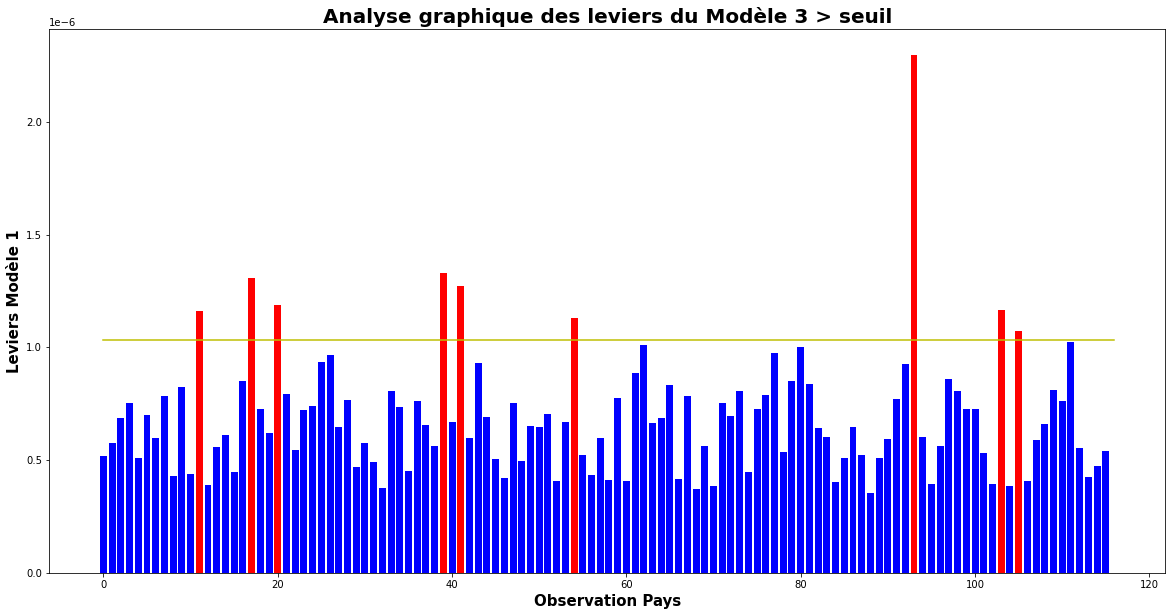

In [30]:
plt.figure(figsize=(20,10))

plt.bar(analyse_levier.loc[analyse_levier['levier_m_3'] <= seuil_levier]['country'].index,
        analyse_levier.loc[analyse_levier['levier_m_3'] <= seuil_levier]['levier_m_3'], color='b')
plt.bar(analyse_levier.loc[analyse_levier['levier_m_3'] > seuil_levier]['country'].index,
        analyse_levier.loc[analyse_levier['levier_m_3'] > seuil_levier]['levier_m_3'], color='r')
plt.plot([0, 116], [seuil_levier, seuil_levier], color='y')

plt.xlabel('Observation Pays', fontsize=15, fontweight='bold')
plt.ylabel('Leviers Mod√®le 1', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des leviers du Mod√®le 3 > seuil', fontsize=20, fontweight='bold')

plt.savefig('levier_m_3.jpg')
plt.show()

In [31]:
#Liste des pays dont le levier est sup√©rieur au seuil fix√©
print('Pays issus du Mod√®le 3 avec log.')
display(analyse_levier[analyse_levier['levier_m_3'] > seuil_levier]['country'])

Pays issus du Mod√®le 3 avec log.


11                                   Brazil
17                          Central African
20                                 Colombia
39                                Guatemala
41                                 Honduras
54                                    Kenya
93                             South Africa
103    The Democratic Republic Of The Congo
105                             Timor-Leste
Name: country, dtype: object

In [32]:
print("Mod√®le 3 (avec log): " + str(round(len(analyse_levier[analyse_levier['levier_m_3'] 
                    > seuil_levier])/len(analyse_levier['levier_m_3'])*100, 2)) + '%')

Mod√®le 3 (avec log): 7.76%


#### Calcule des r√©sidus studentis√©s
Les r√©sidus sont dits studentis√©s lorsqu‚Äôils sont divis√©s par leur √©cart-type empirique. Le seuil pour les r√©sidus studentis√©s est une loi de Student n-p-1√†  degr√©s de libert√© et pour les grands √©chantillons, ils doivent rester compris entre -2 et 2 :

In [33]:
levier_analyse['rstudent_m_3'] = rl_3.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

In [34]:
residus_student = levier_analyse.groupby(['country', 'quantile']).mean().reset_index()

#### Visualisation 

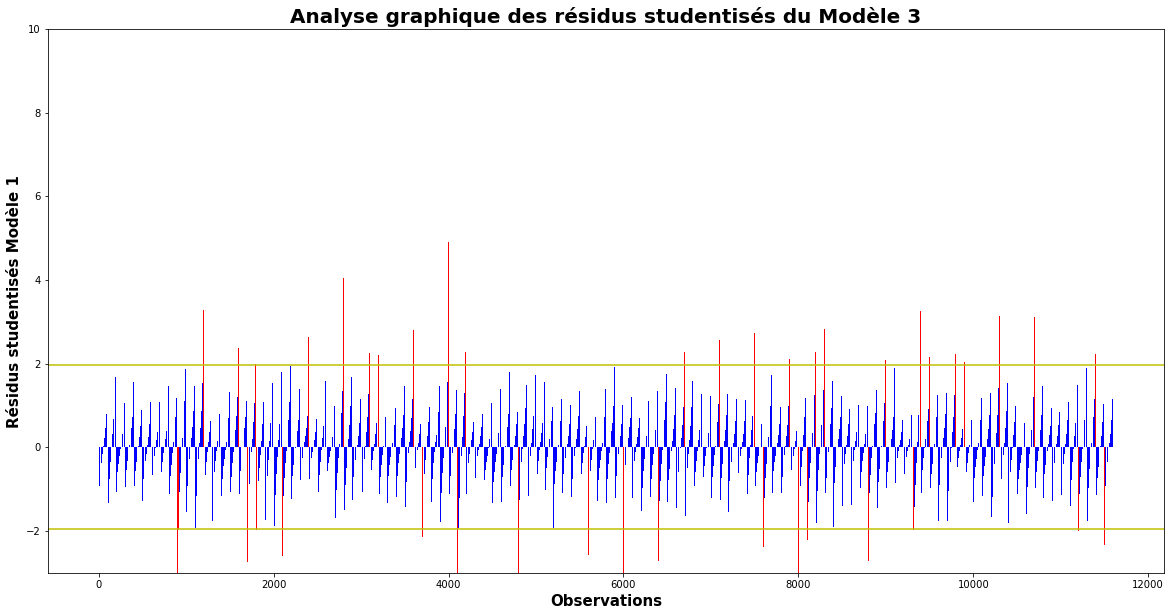

In [35]:
plt.figure(figsize=(20,10))

plt.bar(residus_student[(residus_student['rstudent_m_3'] <= seuil_rstudent) & 
                            (residus_student['rstudent_m_3'] >= -seuil_rstudent)]['country'].index, 
        residus_student[(residus_student['rstudent_m_3'] <= seuil_rstudent) &
                            (residus_student['rstudent_m_3'] >= -seuil_rstudent)]['rstudent_m_3'], color='b')

plt.bar(residus_student[residus_student['rstudent_m_3'] > seuil_rstudent]['country'].index, 
        residus_student[residus_student['rstudent_m_3'] > seuil_rstudent]['rstudent_m_3'], color='r')
plt.bar(residus_student[residus_student['rstudent_m_3'] < -seuil_rstudent]['country'].index, 
        residus_student[residus_student['rstudent_m_3'] < -seuil_rstudent]['rstudent_m_3'], color='r')


plt.axhline(y=seuil_rstudent, color='y', linestyle='-')
plt.axhline(y=-seuil_rstudent, color='y', linestyle='-')

plt.xlabel('Observations', fontsize=15, fontweight='bold')
plt.ylabel('R√©sidus studentis√©s Mod√®le 1', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des r√©sidus studentis√©s du Mod√®le 3', fontsize=20, fontweight='bold')

plt.ylim(-3, 10)
plt.savefig('rstudent_m_3.jpg')
plt.show()

In [42]:
print(str(len(residus_student[(residus_student['rstudent_m_3'] > seuil_rstudent) | 
                 (residus_student['rstudent_m_3'] < -seuil_rstudent)])), 
                 'Valeurs influentes dans le Mod√®le 3 (avec log)')

622 Valeurs influentes dans le Mod√®le 3 (avec log)


In [43]:
#Pourcentage des observations les plus influentes (hors seuil)
print("Mod√®le 3 (avec log): " + str((round(635 / len(residus_student['rstudent_m_3'])*100, 2))) + "%")

Mod√®le 3 (avec log): 5.47%


#### Test de colin√©arit√© 

In [36]:
variables = rl_3.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0642185747001767, 1.064218078454283, 1.0000009381044521]

Ici, tous les coefficients sont inf√©rieurs √† 10, il n'y a donc pas de probl√®me de colin√©arit√©.

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = rl_3.model.exog
vif = [variance_inflation_factor(variables, exog_idx = i) for i in np.arange(1,variables.shape[1])]

In [45]:
df_vif = pd.DataFrame(index = anova_table_global_ln.index[0:-1], columns = ["VIF"])
df_vif["VIF"] = vif
df_vif

VIF
ln_avg_income  1.064219
gini           1.064218
c_k_parent     1.000001

#### Testez l‚Äôhomosc√©dasticit√©
On peut √©galement tester l‚Äôhomosc√©dasticit√© (c'est-√†-dire la constance de la variance) des r√©sidus :

In [37]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(rl_3.resid, variables)
print('p value test Breusch Pagan mod√®le 3:', pval)

p value test Breusch Pagan mod√®le 3: 0.0


La p-valeur ici est inf√©rieure √† 5 %, on rejette l'hypoth√®se ùêª0 selon laquelle les variances sont constantes (l'hypoth√®se d‚Äôhomosc√©dasticit√©).

#### Test de la normalit√© des r√©sidus
Nous allons dans un premier temps r√©aliser un test de Shapiro-Wilk :

In [38]:
shapiro(rl_3.resid)

C:\Users\elodi\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9755378365516663, pvalue=0.0)

On remarque ici que l'hypoth√®se de normalit√© est rejet√©e au niveau de test 5%, mais nous avons un warning d√ª au grand nombre d'individus. Tra√ßons donc la distribution des r√©sidus avec Seaborn pour v√©rifier :

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


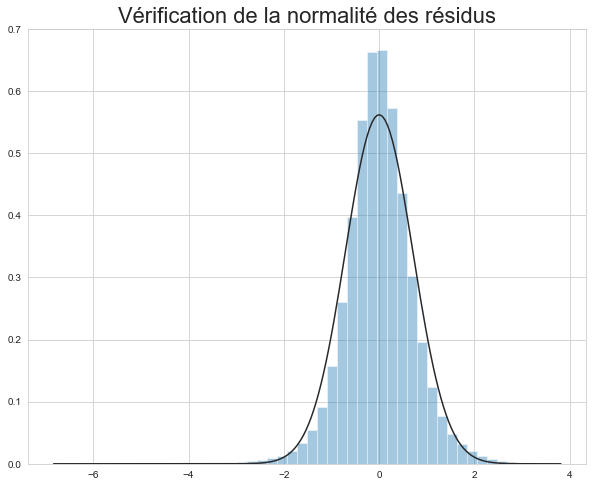

In [39]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(10,8))
ax = sns.distplot(rl_3.resid, fit=st.norm, kde=False)
ax.set_title("V√©rification de la normalit√© des r√©sidus", fontsize=22)
plt.show()

Sur ce graphique, on remarque donc que la distribution des r√©sidus suit bien une distribution normale. Affichons le QQPlot pour terminer cette analyse.

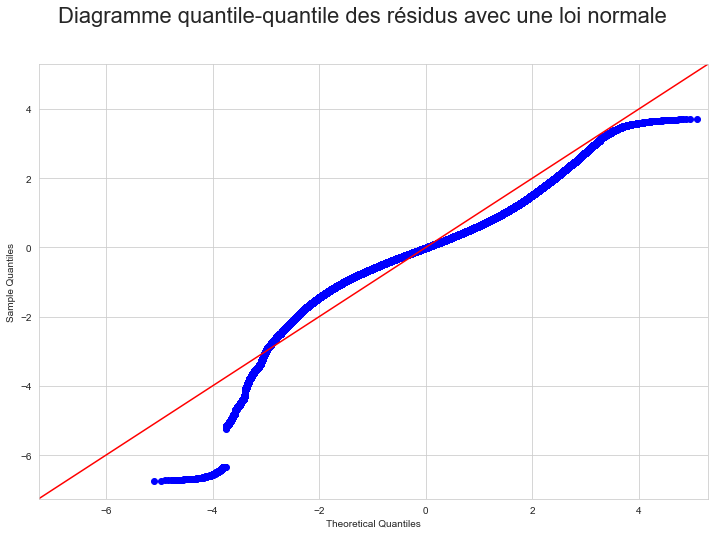

In [40]:
fig = sm.qqplot(rl_3.resid, line="45")
fig.set_size_inches(12, 8)
fig.suptitle("Diagramme quantile-quantile des r√©sidus avec une loi normale", fontsize=22)
plt.show()

### En observant le coefficient de r√©gression associ√© √† l‚Äôindice de Gini, peut-on affirmer que le fait de vivre dans un pays plus in√©galitaire favorise plus de personnes qu‚Äôil n‚Äôen d√©favorise ?

Comme nous l'avons vu, plus l'indice de Gini est √©lev√©, plus la r√©partition du pays est in√©galitaire. De ce fait, une petite proportion de la population d√©tient la plus grosse part des richesses. Les √©carts de salaires sont tr√®s √©lev√©s avec des revenus par individus faibles.

Le coefficient de r√©gression de l'indice de Gini, ne nous permet pas d'affirmer que le fait de vivre dans un pays plus in√©galitaire favorise plus de personnes qu'il n'en d√©favorise.